# Melanoma Detection

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the 
International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken 
with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles,
whose images are slightly dominant.

The data set contains the following diseases:

1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion

**Importing Skin Cancer Data**

In [ ]:
#Connecting with google drive
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Rescaling, InputLayer

In [ ]:
# Check for keras version
import keras
print(keras.__version__)

2.8.0


In [ ]:
# Defining the path for train and test images fromgoogle drive
#root_path='/content/gdrive/MyDrive/CNN/Skin'
#data_dir_train = pathlib.Path(root_path+"/Train")
#data_dir_test = pathlib.Path(root_path+"/Test")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing from google drive
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
#Count number images present in dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
# Splitting train and validation dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Creating validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Listing out all the classes of skin cancer
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
# Listing out train images in each classes
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


In [ ]:
# Finding how many test images belong to each class
for i in class_names:
  print(i,": ",len(list(data_dir_test.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  16
basal cell carcinoma :  16
dermatofibroma :  16
melanoma :  16
nevus :  16
pigmented benign keratosis :  16
seborrheic keratosis :  3
squamous cell carcinoma :  16
vascular lesion :  3


**Visualize the data**
   
Visualizing one image from each class of train data

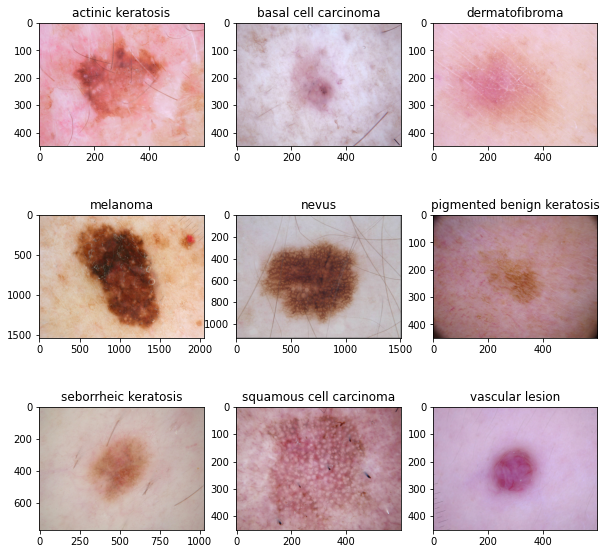

In [ ]:
plt.figure(figsize=(10,10))
for index,images in enumerate(class_names):
  
  temp=plt.imread(list(data_dir_train.glob('{}/*.jpg'.format(images)))[0])
  
  plt.subplot(3,3,index+1)
  plt.imshow(temp)
  plt.axis('on')
  plt.title(images)
  

In [ ]:
# Image shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Data Standaradization**

Standardizing values to be in [0,1] for better neural network performance

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

**Create the model  (Model 1)**

Creating a CNN model, which can accurately detect 9 classes present in the dataset. 

In [ ]:
model=Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(16, 3, activation='relu',padding='same', input_shape = (180, 180, 32)))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, activation='relu',padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

**Compile the model**

Choosing the following appropirate optimiser and loss function for model training

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**Train the model**

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 128s 2s/step - loss: 2.1626 - accuracy: 0.1869 - val_loss: 2.0308 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 2.0004 - accuracy: 0.2500 - val_loss: 1.9126 - val_accuracy: 0.3289
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 1.8422 - accuracy: 0.3298 - val_loss: 1.8422 - val_accuracy: 0.3579
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.6442 - accuracy: 0.4163 - val_loss: 1.5390 - val_accuracy: 0.4676
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4913 - accuracy: 0.4911 - val_loss: 1.4724 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3763 - accuracy: 0.5201 - val_loss: 1.4123 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.2774 - accuracy: 0.5547 - val_loss: 1.3819 - val_accuracy: 0.5436
Epoch 8/20
56

**Visualizing training results**

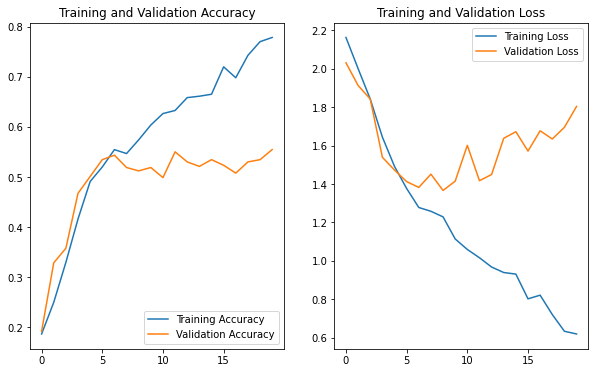

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Result:**

Train Accuracy - 0.7785

Train Loss - 0.5548

Validation Accuracy - 0.56

Validation Loss - 1.8036

**Outcomes:** 

model is overfitting as validation accuracy platued after a while while train accuracy is very high which is in this case .88. Very low values of training loss also indicates than validation loss indicates overfitting

**Solution:**

Data Augmentation and dropout layer changes can decrease this overfitting

**Data Augmentation**

Applying Data Augmentation techniques like flip,rotation and zoom

In [ ]:
image_aug = keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')])

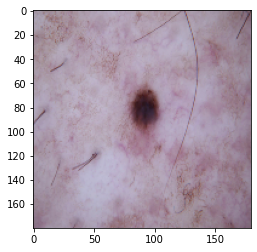

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_aug1=ImageDataGenerator(rescale=1./255,
                   horizontal_flip=True,
                   zoom_range=0.2)
image_batch,label_batch=next(iter(train_ds))
temp=image_batch[0].numpy()
plt.imshow(temp.astype('uint8'))

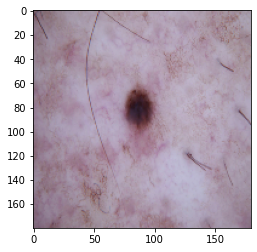

In [ ]:
#visualize how your augmentation strategy works for one instance of training image.
plt.imshow(image_aug1.apply_transform(temp,transform_parameters={'flip_horizontal':True}).astype('uint8'))

**Model 2:**

In [ ]:
# Create the model
model1=Sequential([image_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model1.add(Conv2D(16, 3, activation='relu',padding='same',input_shape = (180, 180, 32)))
model1.add(MaxPooling2D())

model1.add(Conv2D(32, 3, activation='relu',padding='same'))
model1.add(MaxPooling2D())
model1.add(Conv2D(64, 3, activation='relu',padding='same'))
model1.add(MaxPooling2D())
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(9, activation='softmax'))


In [ ]:
# Compile the model
model1.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
# Training the model
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 60ms/step - loss: 1.9938 - accuracy: 0.2852 - val_loss: 1.7934 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6569 - accuracy: 0.4107 - val_loss: 1.6570 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 3s 55ms/step - loss: 1.5774 - accuracy: 0.4425 - val_loss: 1.5380 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 3s 56ms/step - loss: 1.4629 - accuracy: 0.4805 - val_loss: 1.4529 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.3731 - accuracy: 0.5151 - val_loss: 1.3848 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 3s 56ms/step - loss: 1.2971 - accuracy: 0.5424 - val_loss: 1.3337 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.3161 - accuracy: 0.5318 - val_loss: 1.4246 - val_accuracy: 0.5145
Epoch 8/20
56

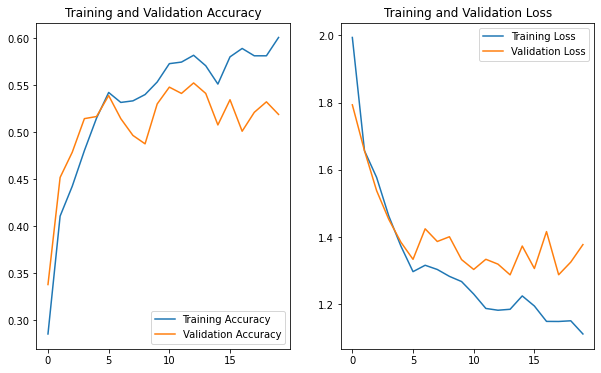

In [ ]:
# Visualizing the result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Result:**

Train Accuracy - 0.60
Validation Accuracy - 0.5190

Train Loss - 1.117

Validation Loss - 1.3776

**Outcomes:**

Here its an underfit model and we can see that Train accuracy is very low even though its near to validation accuracy. 

**Solution:**

Class imbalance might be caausing this issue as see in number of images present for each class.Augmentation can be also be done 

**Checking for class imbalance:**

Many datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


<BarContainer object of 9 artists>

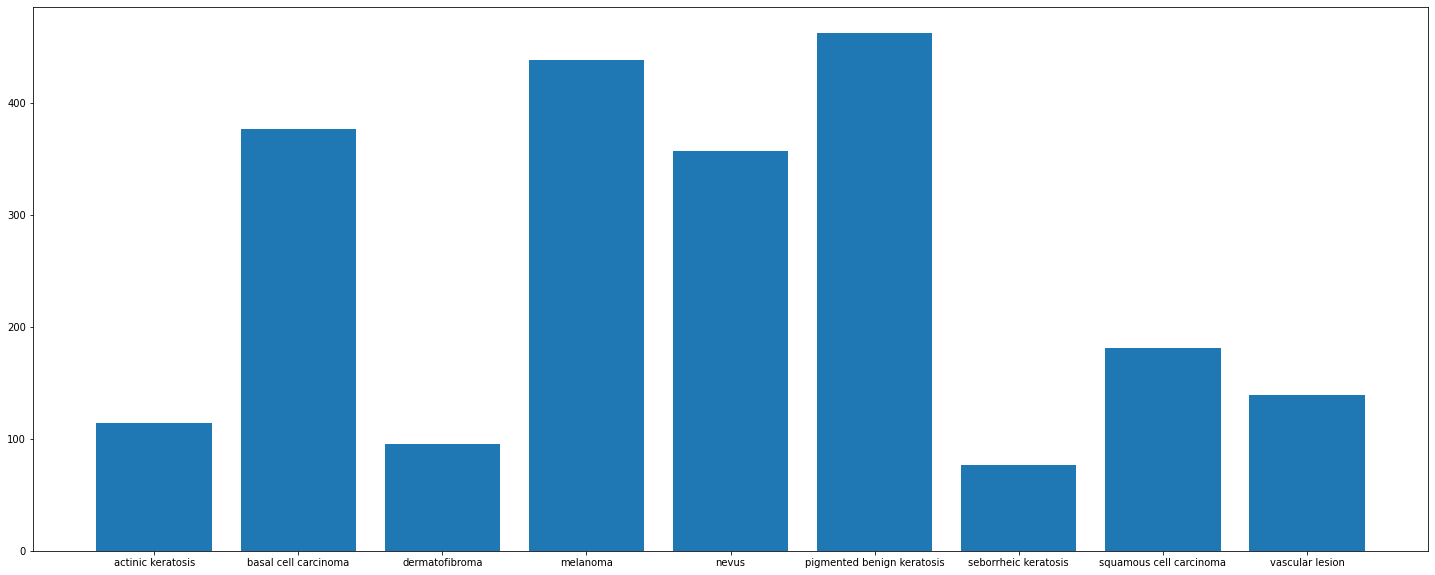

In [ ]:
# Visualize class imbalance through chart
number=[]
for i in class_names:
    number.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,number)

'seborrheic keratosis' has lowest number of image with 77

'pigmented benign keratosis' has more higher number of image with 462 

In [ ]:
# checking label
path=[]
lesion=[]
for i in class_names:
      for j in data_dir_train.glob(i+'/*.jpg'):
        path.append(str(j))
        lesion.append(i)
dataframe_dict_original = dict(zip(path, lesion))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
1,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
2,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
3,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
4,/content/drive/MyDrive/CNN_assignment/Skin can...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2235,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2236,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2237,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion


**Augmentor Package**

A python package known as Augmentor is used to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
# Install Augmentor
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
import Augmentor
for i in class_names:
  augmnt_pipeline = Augmentor.Pipeline(str(data_dir_train) + '/'+ i)
  augmnt_pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  augmnt_pipeline.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC28C4F1350>: 100%|██████████| 500/500 [00:25<00:00, 19.83 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC306B86090>: 100%|██████████| 500/500 [00:26<00:00, 18.71 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC306C50490>: 100%|██████████| 500/500 [00:26<00:00, 19.12 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FC28D0D3510>: 100%|██████████| 500/500 [01:42<00:00,  4.90 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC28C474C10>: 100%|██████████| 500/500 [01:31<00:00,  5.48 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC306C14450>: 100%|██████████| 500/500 [00:23<00:00, 21.52 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC28C465AD0>: 100%|██████████| 500/500 [00:50<00:00,  9.97 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC306BF9C10>: 100%|██████████| 500/500 [00:22<00:00, 22.59 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC306C4BBD0>: 100%|██████████| 500/500 [00:22<00:00, 22.32 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Checking distribution of augmented data after adding new images to the original training data.**

In [ ]:
import os
import glob
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

Now we have added 500 images to all the classes to maintain some class balance.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

**Creating a training dataset**

In [ ]:
augmented_data_dir = data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Creating a validation dataset**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Model 3:**

In [ ]:
#Model from augmented data
model_norm=Sequential()

model_norm.add(InputLayer((180,180,3)))
model_norm.add(Rescaling(1./255))

model_norm.add(Conv2D(32, (3, 3), padding='same'))
model_norm.add(BatchNormalization())
model_norm.add(Activation('relu'))

model_norm.add(MaxPooling2D(pool_size=(2, 2)))

model_norm.add(Conv2D(64, (3, 3)))
model_norm.add(BatchNormalization())
model_norm.add(Activation('relu'))


model_norm.add(MaxPooling2D(pool_size=(2, 2)))
model_norm.add(Dropout(0.25))

model_norm.add(Flatten())
model_norm.add(Dense(512, activation='relu'))
model_norm.add(Dense(256, activation='relu'))
model_norm.add(Dropout(0.25))

model_norm.add(Dense(9, activation='softmax'))


# View the summary of all layers
model_norm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 64)       

**Compile Model**

In [ ]:
#choose an appropirate optimiser and loss function
model_norm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

**Train the model**

In [ ]:
epochs = 50
history = model_norm.fit(
  train_ds,
  validation_data=val_ds ,
  epochs=epochs,
)


Epoch 1/50
169/169 [==============================] - 43s 243ms/step - loss: 1.9082 - accuracy: 0.2966 - val_loss: 2.1256 - val_accuracy: 0.2049
Epoch 2/50
169/169 [==============================] - 42s 241ms/step - loss: 1.7974 - accuracy: 0.3244 - val_loss: 1.9298 - val_accuracy: 0.2843
Epoch 3/50
169/169 [==============================] - 43s 249ms/step - loss: 1.6733 - accuracy: 0.3680 - val_loss: 1.5949 - val_accuracy: 0.3823
Epoch 4/50
169/169 [==============================] - 42s 239ms/step - loss: 1.6010 - accuracy: 0.3833 - val_loss: 1.4640 - val_accuracy: 0.4336
Epoch 5/50
169/169 [==============================] - 42s 241ms/step - loss: 1.5616 - accuracy: 0.3874 - val_loss: 2.0390 - val_accuracy: 0.3482
Epoch 6/50
169/169 [==============================] - 42s 240ms/step - loss: 1.5464 - accuracy: 0.3889 - val_loss: 1.6139 - val_accuracy: 0.4209
Epoch 7/50
169/169 [==============================] - 42s 240ms/step - loss: 1.4901 - accuracy: 0.4165 - val_loss: 1.4365 - val_ac

**Visualizing the result**

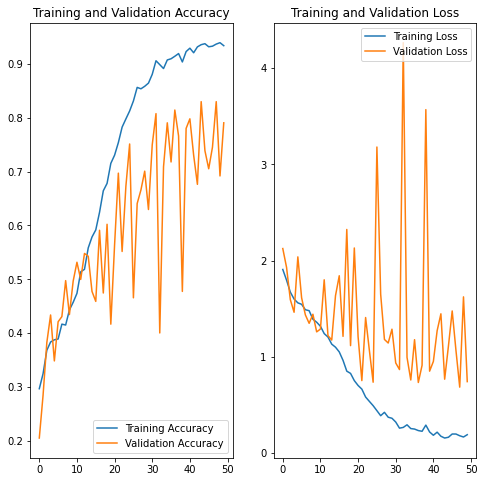

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**outcome:**

Train Accuracy - 0.934

Validation Accuracy - 0.79

Train Loss - 0.1922

Validation Loss - 0.7435

**Findings:**

Discrepancy between training accuracy and validation accuracy has reduced but still model is overfitting

So use of class rebalance and augmentation and if you notice epoch 48 we can observe very good results.So class reblance did help

**Solution:**

Hyper parameter tuning can further reduce overfitting of the model

## Conclusion:

With data augmentation and class rebalance we can see that overfitting and underfitting issues can be minimised which helps in getting better prediction models


